In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Required for progressbar widget
import progressbar

In [2]:
train_terms = pd.read_csv('../data/cafa-5-protein-function-prediction/Train/train_terms.tsv',sep="\t")
train_protein_ids = np.load('../data/cafa-5-protein-function-prediction/Train/train_ids.npy')
train_embeddings = np.load('../data/cafa-5-protein-function-prediction/Train/train_embeds.npy')

# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])

In [4]:
train_terms.term.nunique()

31466

In [45]:
# Set the limit for label
num_of_labels = 1500

# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = train_terms['term'].value_counts().index[:num_of_labels].tolist()
# Fetch the train_terms data for the relevant labels only
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]

In [46]:
# Setup progressbar settings.
# This is strictly for aesthetic.
bar = progressbar.ProgressBar(maxval=num_of_labels,
                              widgets=[progressbar.Bar('=', '[', ']'),
                                       ' ', progressbar.Percentage()])

# Create an empty dataframe of required size for storing the labels,
# i.e, train_size x num_of_labels (142246 x 1500)
train_size = train_protein_ids.shape[0] # len(X)
train_labels = np.zeros((train_size ,num_of_labels))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(train_protein_ids)

In [47]:
%%time
# Loop through each label
bar.start()
for i in range(num_of_labels):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]
    
    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['EntryID'].unique()
    
    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)
    
    # Progress bar percentage increase
    bar.update(i+1)

# Notify the end of progress bar 
bar.finish()

CPU times: user 5min 39s, sys: 5.11 s, total: 5min 44s
Wall time: 6min 49s


In [48]:
# Convert train_Y numpy into pandas dataframe
labels_df = pd.DataFrame(data = train_labels, columns = labels)

In [49]:
labels_df.sum()

GO:0005575    92912.0
GO:0008150    92210.0
GO:0110165    91286.0
GO:0003674    78637.0
GO:0005622    70785.0
               ...   
GO:0051783      431.0
GO:0031674      431.0
GO:0001818      431.0
GO:0006874      430.0
GO:0016887      430.0
Length: 1500, dtype: float64

# Training

Next, we will use Tensorflow to train a Deep Neural Network with the protein embeddings.

In [50]:
%%time
INPUT_SHAPE = [train_df.shape[1]]
BATCH_SIZE = 5120

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels,activation='sigmoid')
])


# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

history = model.fit(
    train_df, labels_df,
    batch_size=BATCH_SIZE,
    epochs=5
)

Epoch 1/5
28/28 [==============================] - 7s 231ms/step - loss: 0.2023 - binary_accuracy: 0.9387 - auc_1: 0.6802
Epoch 2/5
28/28 [==============================] - 6s 222ms/step - loss: 0.0782 - binary_accuracy: 0.9801 - auc_1: 0.8326
Epoch 3/5
28/28 [==============================] - 7s 258ms/step - loss: 0.0735 - binary_accuracy: 0.9803 - auc_1: 0.8619
Epoch 4/5
28/28 [==============================] - 7s 243ms/step - loss: 0.0694 - binary_accuracy: 0.9805 - auc_1: 0.8883
Epoch 5/5
28/28 [==============================] - 6s 228ms/step - loss: 0.0666 - binary_accuracy: 0.9807 - auc_1: 0.9040
CPU times: user 3min 19s, sys: 41 s, total: 4min
Wall time: 35.4 s


# Plot the model's loss and accuracy for each epoch

<Axes: title={'center': 'Accuracy'}>

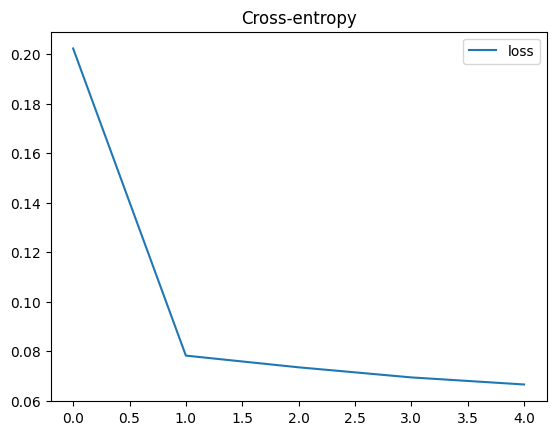

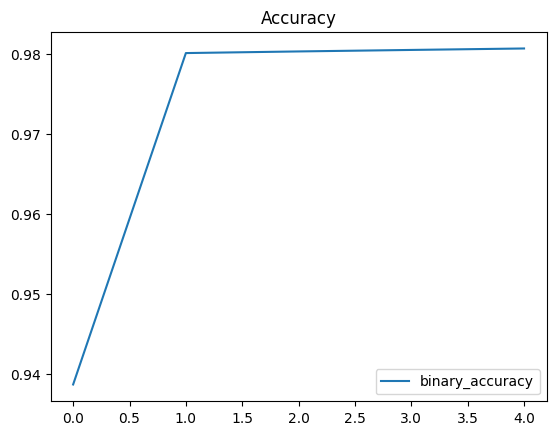

In [51]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy']].plot(title="Accuracy")

# Submission

For submission we will use the protein embeddings of the test data created by [Sergei Fironov](https://www.kaggle.com/sergeifironov) using the Rost Lab's T5 protein language model.

In [52]:
test_embeddings = np.load('../data/cafa-5-protein-function-prediction/Test (Targets)/test_embeds.npy')

# Convert test_embeddings to dataframe
column_num = test_embeddings.shape[1]
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)

(141865, 1024)


The `test_df` is composed of 1024 columns and 141865 entries. We can see all 1024 dimensions(results will be truncated since column length is too long) of our dataset by printing out the first 5 entries using the following code:

In [53]:
test_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.054705,0.063420,-0.015320,-0.016506,0.042195,0.021592,-0.118535,-0.063298,-0.046146,-0.102311,...,-0.019581,-0.043712,-0.072322,0.002404,0.018459,-0.047278,0.012195,-0.043319,0.036009,0.063093
1,0.090373,0.089842,-0.023887,-0.011446,0.051465,0.020982,-0.110989,-0.066646,-0.041259,-0.087551,...,-0.024399,-0.041957,-0.066329,0.006856,0.028449,-0.053758,0.009699,-0.053350,0.019644,0.079630
2,0.043588,0.039572,-0.014332,-0.011769,0.045109,0.015847,-0.103339,-0.047735,-0.022730,-0.091452,...,-0.029648,-0.037944,-0.046043,0.003603,0.018028,-0.030746,0.003671,-0.044464,0.030974,0.040322
3,0.055668,0.049560,-0.019646,-0.006977,0.039897,0.021177,-0.108079,-0.047191,-0.031517,-0.100057,...,-0.023210,-0.041704,-0.048440,0.006088,0.020110,-0.046751,-0.006635,-0.041455,0.016683,0.057030
4,0.022637,0.014306,-0.002696,-0.034456,0.034854,0.020822,-0.114046,-0.050019,-0.026491,-0.097928,...,-0.019185,-0.032108,-0.051394,0.008448,0.015208,-0.037987,0.030977,-0.042407,0.041232,0.047161


We will now use the model to make predictions on the test embeddings. 

In [54]:
predictions =  model.predict(test_df)

4434/4434 [==============================] - 7s 2ms/step


From the predictions we will create the submission data frame.

**Note**: This will take atleast **15 to 20** minutes to finish.

In [55]:
# Reference: https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary

df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
test_protein_ids = np.load('../data/cafa-5-protein-function-prediction/Test (Targets)/test_ids.npy')

In [56]:
l = []
for k in list(test_protein_ids):
    l += [ k] * predictions.shape[1]   

In [57]:
%%time
df_submission['Protein Id'] = l
df_submission['GO Term Id'] = labels * predictions.shape[0]
df_submission['Prediction'] = predictions.round(3).ravel()
#df_submission.to_csv("submission.tsv",header=False, index=False, sep="\t")

In [58]:
df_submission

,Protein Id,GO Term Id,Prediction
0,Q9CQV8,GO:0005575,0.526
1,Q9CQV8,GO:0008150,0.523
2,Q9CQV8,GO:0110165,0.523
3,Q9CQV8,GO:0003674,0.518
4,Q9CQV8,GO:0005622,0.514
...,...,...,...
212797495,A0A3G2FQK2,GO:0051783,0.299
212797496,A0A3G2FQK2,GO:0031674,0.332
212797497,A0A3G2FQK2,GO:0001818,0.332
212797498,A0A3G2FQK2,GO:0006874,0.302


In [59]:
df_submission.query("Prediction == 0.000")

,Protein Id,GO Term Id,Prediction
